In [ ]:
# Only run this cell when in Google Colab
! git init
! git remote add origin 
! git fetch
! git checkout -t origin/main

In [ ]:
! wget -q --show-progress 
! unzip -qq -o data.zip

In [76]:
from src.process import read_and_split_data, subsample_features
from src.model import train_candidates, cluster_predictions, compute_cluster_representatives, root_mean_square_error, plot_clustering
from src.predict import predict_n_steps_for_ensemble, predict_one_step_for_ensemble, get_weights, final_prediction_ensemble
import os
import pandas as pd
from config import EXPERIMENT_NAME, VALIDATION_WINDOW_SIZE, WEIGHTS_WINDOW_SIZE, EVALUATION_WINDOW, TARGET_INDEX, SUBSET_SIZE, K

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
train, val, test = read_and_split_data(EXPERIMENT_NAME + '\\NEW-DATA-1.T15-PREPROCESSED.csv', val_size=VALIDATION_WINDOW_SIZE)

In [4]:
# Hyperparameters
target_index = TARGET_INDEX
subset_size = SUBSET_SIZE
k = K

In [5]:
sample_subsets = subsample_features(train, target_index, subset_size, k)

In [7]:
train_candidates(train, val, target_index, sample_subsets)

Validation error for model 1 is 0.02570256869181366.
Validation error for model 2 is 0.0172512253546439.
Validation error for model 3 is 0.022597810399620544.
Validation error for model 4 is 0.02676636868200338.
Validation error for model 5 is 0.029909189599715.
Validation error for model 6 is 0.028337842497853757.
Validation error for model 7 is 0.026913882366978604.
Validation error for model 8 is 0.02676636868200338.
Validation error for model 9 is 0.034976684698809685.
Validation error for model 10 is 0.02844111883493983.
Validation error for model 11 is 0.028445809503063926.
Validation error for model 12 is 0.0033459065258501313.
Validation error for model 13 is 0.00321687122942035.
Validation error for model 14 is 0.029909189599715003.
Validation error for model 15 is 0.030044307184518768.
Validation error for model 16 is 0.023985889545328955.
Validation error for model 17 is 0.028272440060215738.
Validation error for model 18 is 0.0246352025600315.
Validation error for model 19 

In [40]:
VALIDATION_FILENAME = os.path.join(os.getcwd(), 'experiments', EXPERIMENT_NAME, 'validation_predictions_init.csv')

In [41]:
validation_pred = pd.read_csv(VALIDATION_FILENAME)

In [55]:
cluster_result, cluster_centers = cluster_predictions(validation_pred)

Determined number of clusters: 15


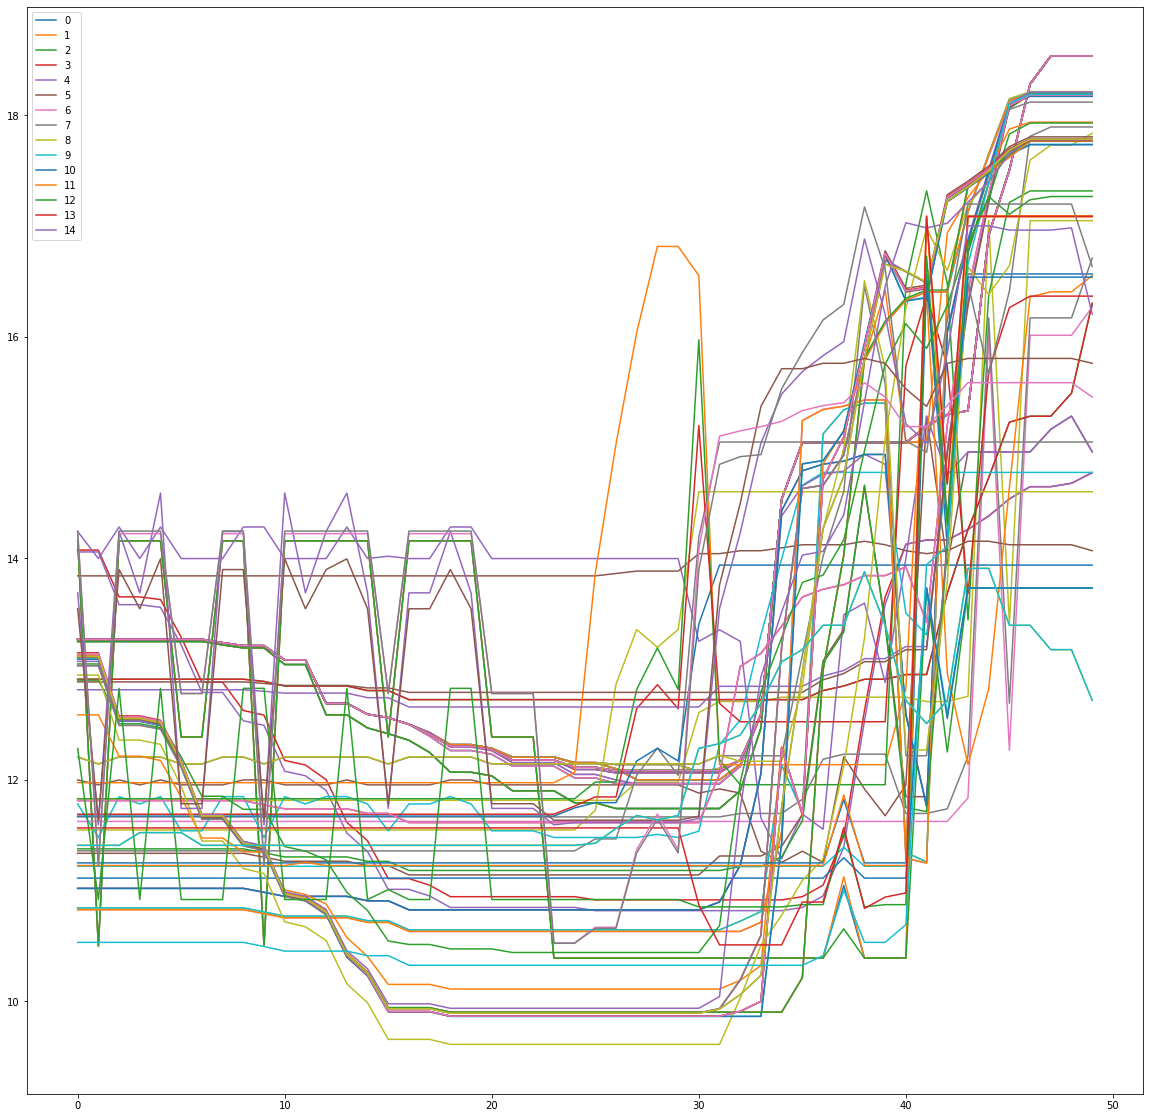

In [77]:
plot = plot_clustering(cluster_result, validation_pred)
plot.show()

In [66]:
ensemble = compute_cluster_representatives(cluster_result, cluster_centers, validation_pred)

In [35]:
from src.drift import PageHinkley, DataDrift
ph = PageHinkley(delta=0.005, threshold=0.025)
hoeffding = DataDrift(threshold=0.95)

In [15]:
all_model_indices = list(map(str, list(range(1, len(sample_subsets)+1))))

In [16]:
from src.model import save_validation_predictions

In [36]:
def compute_ensemble(X, running_version_name):
    val_predictions = predict_n_steps_for_ensemble(all_model_indices, X, sample_subsets)
    val_predictions = pd.DataFrame(val_predictions)

    save_validation_predictions(val_predictions, running_version_name)
    cluster_result, cluster_centers = cluster_predictions(val_predictions)
    ensemble = compute_cluster_representatives(cluster_result, cluster_centers, val_predictions)

    return list(map(str, ensemble))

In [37]:
validation = pd.concat([val, test], axis=0)

In [ ]:
start_index = 0
test_predictions = []
evaluation_sliding_window_start = 0
version = 1
while start_index < (len(test) - WEIGHTS_WINDOW_SIZE):
    end_index = start_index + WEIGHTS_WINDOW_SIZE
    X_window = test.iloc[start_index:end_index, ]
    y_window = test.iloc[start_index:end_index, target_index]
    X = test.iloc[end_index, ]
    print(start_index)
    weights = get_weights(ensemble, X_window, y_window, sample_subsets)
    pred_at_t = final_prediction_ensemble(ensemble, X, sample_subsets, weights)
    test_predictions.append(pred_at_t)
    if(len(test_predictions) >= EVALUATION_WINDOW):
        X = test.iloc[WEIGHTS_WINDOW_SIZE+evaluation_sliding_window_start:WEIGHTS_WINDOW_SIZE+evaluation_sliding_window_start+EVALUATION_WINDOW, test.columns!=test.columns[target_index]]
        y = test.iloc[WEIGHTS_WINDOW_SIZE+evaluation_sliding_window_start:WEIGHTS_WINDOW_SIZE+evaluation_sliding_window_start+EVALUATION_WINDOW, target_index]
        y_predicted = test_predictions[evaluation_sliding_window_start:evaluation_sliding_window_start+EVALUATION_WINDOW]
        error = root_mean_square_error(y.to_numpy(), y_predicted)
        print(f'Error for window [{WEIGHTS_WINDOW_SIZE+evaluation_sliding_window_start}:{WEIGHTS_WINDOW_SIZE+evaluation_sliding_window_start+EVALUATION_WINDOW}] is {error}')
        ph.add_element(error)
        print(f'Difference: {ph.sum - ph.minimum}')

        glob_min = hoeffding.min
        hoeffding.add_element(X, y)
        print(f'Hoeffding global minimum: {glob_min}. Latest minimum: {hoeffding.min2}. Sample count: {hoeffding.sample_count}')
        if ph.detected_change():
            print('Change in error detected.')
        if hoeffding.detected_change():
            print('Change in data detected')
        if ph.detected_change() | hoeffding.detected_change():
            X_val = validation.iloc[end_index:end_index + VALIDATION_WINDOW_SIZE, ]
            ensemble = compute_ensemble(X_val, version)
            version += 1
        evaluation_sliding_window_start += 1
    start_index = start_index + 1

In [86]:
root_mean_square_error(test.iloc[WEIGHTS_WINDOW_SIZE:, target_index].to_numpy(), test_predictions)

0.01919480659591487

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

save_name = EXPERIMENT_NAME + '_results.csv'
path = F'/content/drive/MyDrive/Colab Notebooks/{save_name}'
test_predictions.to_csv(path)